In [118]:
import psycopg2
import pandas as pd
import nltk
import spacy 
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from nltk.corpus import stopwords
import string
import numpy as np
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from src import galgraphs as ggal
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bhaskarballapragada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bhaskarballapragada/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [119]:
def retrieve_reviews(product):
    conn = psycopg2.connect(dbname='product_reviews', user='postgres', password='', host='localhost')
    cursor = conn.cursor()
    p_no = 0
    r_no = 0
    cursor.execute("select * from reviews where r_comments like 'Verified%' product_name = '{}'".format(product))
    rows = cursor.fetchall()
    df = pd.DataFrame(rows)
    cursor.close()
    conn.close()
    return df

def retrieve_all_reviews():
    conn = psycopg2.connect(dbname='product_reviews', user='postgres', password='', host='localhost')
    cursor = conn.cursor()
    p_no = 0
    r_no = 0
    cursor.execute("select * from reviews where r_comments like 'Verified%' ")
    rows = cursor.fetchall()
    df = pd.DataFrame(rows)
    cursor.close()
    conn.close()
    return df


In [120]:
df = retrieve_all_reviews()
columns = ['id','p_name','url','p_no','r_no','r_stars','r_date','r_name','r_title','r_text','r_comments', 'brand_name','category','model']
df.columns = columns

df_new = df.copy()
df_new = df_new[df_new['r_stars'].apply(lambda x: x in ['5.0 out of 5 stars','4.0 out of 5 stars','2.0 out of 5 stars','1.0 out of 5 stars'])]
df_new['rating'] = df_new['r_stars'].apply(lambda x: 1 if x in ['5.0 out of 5 stars','4.0 out of 5 stars'] else 0)
df_new = df_new[['rating','p_name','r_name','r_title','r_text']]

df_nb = df_new[['rating','p_name']].copy()
df_nb.columns = ['rating','product']
df_nb['reviews'] = df['r_title'] + ' ' + df['r_text']
df_nb.head(3)

,rating,product,reviews
0,1,Samsung Electronics UN65MU6300 65-Inch 4K Ultr...,Someone here complained that the television is...
1,1,Samsung Electronics UN65MU6300 65-Inch 4K Ultr...,"This is a great tv, after all This is a great ..."
2,0,Samsung Electronics UN65MU6300 65-Inch 4K Ultr...,"Dont waste your money on this, save more than ..."


In [13]:
# from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
# import string
# stopwords = set(stopwords.words('english'))
# punctuation = set(string.punctuation)
# lemmatize = WordNetLemmatizer()

# def cleaning(article):
#     one = " ".join([i for i in article.lower().split() if i not in stopwords])
#     two = "".join(i for i in one if i not in punctuation)
#     three = " ".join(lemmatize.lemmatize(i) for i in two.split())
#     return three

# df_text = df_new[['r_text']]
# df_text.info()

# data = df_text.applymap(cleaning)['r_text']
# text = data
# text_list = [i.split() for i in text]
# len(text_list)

In [113]:
from sklearn.model_selection import train_test_split
df_new['des'] = df_new['r_title'] + " " + df_new['r_text']
df_new.head(2)
X_train, X_test, y_train, y_test = train_test_split(df_nb['reviews'], df_nb['rating'], train_size=0.6)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [114]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

df_nb['rating'].count(), df_nb['rating'].sum()

(3478, 2902)

In [115]:
tfidf = TfidfVectorizer(stop_words='english',max_features=10000)
X_train_descr_vectors = tfidf.fit_transform(X_train)
X_test_descr_vectors = tfidf.transform(X_test)

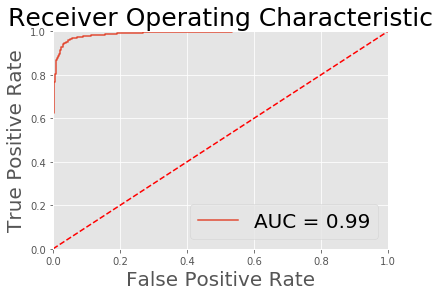

In [116]:
nb = MultinomialNB()
nb.fit(X_train_descr_vectors, y_train.transpose())
y_hat_train = nb.predict_proba(X_train_descr_vectors)
y_hat = nb.predict_proba(X_test_descr_vectors)

fig, ax = plt.subplots(1,1)
ggal.plot_roc(ax, nb, X_train_descr_vectors.todense(), y_train)
plt.show()

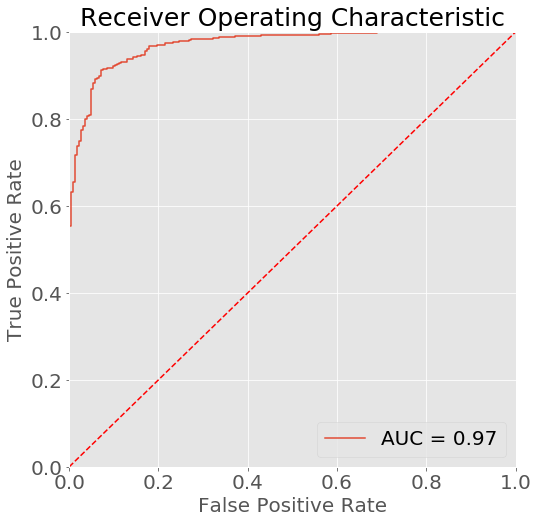

In [117]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ggal.plot_roc(ax, nb, X_test_descr_vectors.todense(), y_test)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [14]:
nlp = spacy.load("en")

def pos_neg_sentiments(df_product):
    #positive sentiments
    g = df_product.groupby('p_name')
    for name, group in g:
        group_pos = group[group['rating'] == 1]
        group_neg = group[group['rating'] == 0]
        
        if ((group_pos.shape[0] > 20) and (group_neg.shape[0] > 20)):
            
            tfidf_pos = TfidfVectorizer(stop_words='english',max_features=10000)

            X_pos_descr_vectors = tfidf_pos.fit_transform(group_pos['des'])
            nb_pos = MultinomialNB()
            nb_pos.fit(X_pos_descr_vectors, group_pos['rating'].transpose()) 
            y_hat_pos = nb_pos.predict_proba(X_pos_descr_vectors)
            arr = np.argsort(nb_pos.feature_log_prob_[0])[-20:-1]
            list_of_pos_words = []
            for i in arr:
                list_of_pos_words.append(tfidf_pos.get_feature_names()[i])
                
            tfidf_neg = TfidfVectorizer(stop_words='english',max_features=10000)            
            X_neg_descr_vectors = tfidf_neg.fit_transform(group_neg['des'])
            nb_neg = MultinomialNB()
            nb_neg.fit(X_neg_descr_vectors, group_neg['rating'].transpose()) 
            y_hat_neg = nb_neg.predict_proba(X_neg_descr_vectors)
            arr = np.argsort(nb_neg.feature_log_prob_[0])[-20:-1]
                
            list_of_neg_words = []
            for i in arr:
                list_of_neg_words.append(tfidf_neg.get_feature_names()[i])

            print (name, '\n')    
            print ("Positive Words \n\t", list_of_pos_words)
            print ("\nNegative Words \n\t", list_of_neg_words)
            print ("______________________________________________________________________________")
            tokens = nlp(' '.join(list_of_pos_words))
            #for token1 in tokens:
                #for token2 in tokens:
                    #print(token1.text, token2.text, token1.similarity(token2))
            
            
            

print (pos_neg_sentiments(df_new))

/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


LG Electronics 65UJ6300 65-Inch 4K Ultra HD Smart LED TV (2017 Model) 

Positive Words 
	 ['excellent', 'value', 'use', 'amazing', 'clear', 'perfect', 'lg', 'easy', 'nice', 'sound', 'works', 'quality', 'awesome', 'price', 'good', 'love', 'picture', 'tv', 'great']

Negative Words 
	 ['shattered', 'disappointed', 'working', 'damaged', 'arrival', 'defective', 'item', 'product', 'picture', 'opened', 'days', 'cracked', 'return', 'came', 'arrived', 'box', 'broken', 'screen', 'tv']
______________________________________________________________________________
Samsung Electronics UN65MU6300 65-Inch 4K Ultra HD Smart LED TV (2017 Model) 

Positive Words 
	 ['beautiful', 'works', 'happy', 'smart', 'amazing', 'awesome', 'sound', 'nice', 'samsung', 'set', 'quality', 'easy', 'price', 'excellent', 'good', 'love', 'picture', 'great', 'tv']

Negative Words 
	 ['bought', 'customer', 'received', 'dont', 'cracked', 'problem', 'service', 'box', 'return', 'just', 'work', 'broken', 'buy', 'picture', 'workin

In [13]:
from src.naive_review_analyzer import NaiveReviewAnalyzer

nra = NaiveReviewAnalyzer(df_nb)

nra.create_bow()

for name, group in df_nb.groupby('product'):
    print(name, '\n\t',nra.create_word_list(product=name, rating=1))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bhaskarballapragada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bhaskarballapragada/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
